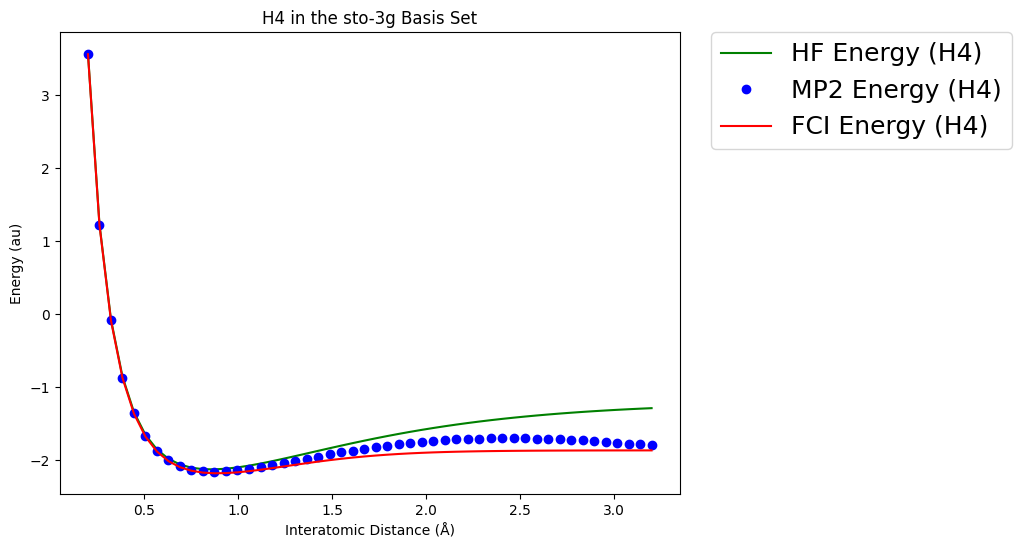

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qat.fermion.chemistry.pyscf_tools import perform_pyscf_computation

# Define the interatomic distances for H4
r_H4 = np.linspace(0.2, 3.2, 50)

# Basis and other parameters
basis = "sto-3g"
spin = 0
charge = 0

mp2Energies_H4 = []
fciEnergies_H4 = []
hfEnergies_H4 = []

# Calculate energies for H4
for distance in r_H4:
    geometry = [
        ('H', (0, 0, 0)),
        ('H', (0, 0, distance)),
        ('H', (0, 0, 2 * distance)),
        ('H', (0, 0, 3 * distance)),
    ]
    (
        rdm1,
        orbital_energies,
        nuclear_repulsion,
        n_electrons,
        one_body_integrals,
        two_body_integrals,
        info,
    ) = perform_pyscf_computation(
        geometry=geometry, basis=basis, spin=spin, charge=charge, run_fci=True
    )
    hfEnergies_H4.append(info['HF'])
    mp2Energies_H4.append(info['MP2'])
    fciEnergies_H4.append(info['FCI'])

# Plot H4 energies
plt.figure(figsize=[8, 6])

plt.plot(r_H4, hfEnergies_H4, color='g', label='HF Energy (H4)')
plt.plot(r_H4, mp2Energies_H4, 'o', color='b', label='MP2 Energy (H4)')
plt.plot(r_H4, fciEnergies_H4, color='r', label='FCI Energy (H4)')

plt.ylabel("Energy (au)")
plt.xlabel("Interatomic Distance (Å)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
plt.title("H4 in the sto-3g Basis Set")

plt.show()


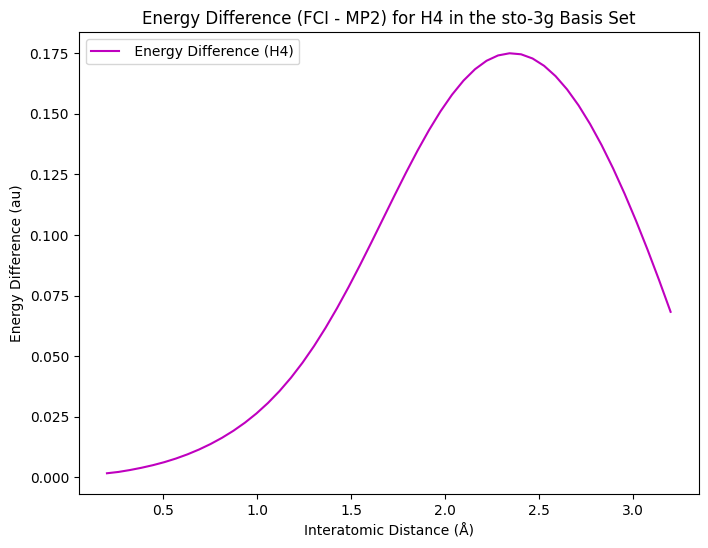

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from qat.fermion.chemistry.pyscf_tools import perform_pyscf_computation

# Define the interatomic distances for H4
r_H4 = np.linspace(0.2, 3.2, 50)

# Basis and other parameters
basis = "sto-3g"
spin = 0
charge = 0

mp2Energies_H4 = []
fciEnergies_H4 = []
energyDifferences_H4 = []

# Calculate energies for H4
for distance in r_H4:
    geometry = [
        ('H', (0, 0, 0)),
        ('H', (0, 0, distance)),
        ('H', (0, 0, 2 * distance)),
        ('H', (0, 0, 3 * distance)),
    ]
    (
        rdm1,
        orbital_energies,
        nuclear_repulsion,
        n_electrons,
        one_body_integrals,
        two_body_integrals,
        info,
    ) = perform_pyscf_computation(
        geometry=geometry, basis=basis, spin=spin, charge=charge, run_fci=True
    )
    mp2Energies_H4.append(info['MP2'])
    fciEnergies_H4.append(info['FCI'])
    energyDifferences_H4.append(abs(info['MP2'] - info['FCI']))

# Plot the FCI - MP2 energy difference as a function of interatomic distance
plt.figure(figsize=[8, 6])

plt.plot(r_H4, energyDifferences_H4, color='m', label=' Energy Difference (H4)')


plt.ylabel("Energy Difference (au)")
plt.xlabel("Interatomic Distance (Å)")
plt.legend()
plt.title("Energy Difference (FCI - MP2) for H4 in the sto-3g Basis Set")

plt.show()


In [18]:
print(info['FCI'])

-1.8667754888683112


### UCC method 


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import product

from qat.qpus import get_default_qpu
from qat.core import Batch, Job

from qat.fermion.transforms import transform_to_jw_basis
from qat.fermion.hamiltonians import make_embedded_model
from qat.fermion.circuits import make_shallow_circ, make_ldca_circ

from qat.fermion.chemistry.pyscf_tools import perform_pyscf_computation
from qat.fermion.chemistry import MolecularHamiltonian, MoleculeInfo
from qat.fermion.trotterisation import make_trotterisation_routine
from qat.fermion.chemistry.ucc import construct_ucc_ansatz, guess_init_params, get_hf_ket, get_cluster_ops
from qat.qpus import get_default_qpu

from qat.plugins import ScipyMinimizePlugin, MultipleLaunchesAnalyzer

/Users/theking/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np
from qat.core import Observable, Term
import numpy as np
import scipy
from numpy import binary_repr
from qat.fermion import ElectronicStructureHamiltonian
from qat.fermion.chemistry.pyscf_tools import perform_pyscf_computation

from qat.lang.AQASM import Program, QRoutine, RY, CNOT, RX, Z, H, RZ, I, X
from qat.core import Observable, Term, Circuit
from qat.lang.AQASM.gates import Gate
import matplotlib as mpl
import numpy as np
from typing import Optional, List
import warnings
from qat.qpus import get_default_qpu

qpu = get_default_qpu()
method = "BFGS"


In [3]:
import numpy as np
import scipy
from numpy import binary_repr
from qat.fermion import ElectronicStructureHamiltonian
from qat.fermion.chemistry.pyscf_tools import perform_pyscf_computation
from qat.fermion.chemistry.ucc import (
    convert_to_h_integrals,
    transform_integrals_to_new_basis,
)
from qat.fermion.chemistry.ucc_deprecated import (
    get_active_space_hamiltonian,
    get_cluster_ops_and_init_guess,
)
from qat.fermion.transforms import (
    get_bk_code,
    get_jw_code,
    get_parity_code,
    recode_integer,
    transform_to_bk_basis,
    transform_to_jw_basis,
    transform_to_parity_basis,
)

from openvqe.common_files.generator_excitations import (
    singlet_gsd,
    singlet_sd,
    singlet_upccgsd,
    spin_complement_gsd,
    spin_complement_gsd_twin,
    uccsd,
)

In [5]:
def Molecule_Generator(model):
    if model == "H2":
        r = 0.98
        geometry = [("H", (0, 0, 0)), ("H", (0, 0, r))]
        charge = 0
        spin = 0
        basis = "sto-3g"
    
    elif model == "H4":
        r = 0.85
        geometry = [
            ("H", (0, 0, 0)),
            ("H", (0, 0, 1 * r)),
            ("H", (0, 0, 2 * r)),
            ("H", (0, 0, 3 * r)),
        ]
        charge = 0
        spin = 0
        basis = "sto-3g"
  
    return r, geometry, charge, spin, basis

In [11]:
name = Molecule_Generator("H4")

In [12]:
r, geometry, charge, spin, basis = name
(
    rdm1,
    orbital_energies,
    nuclear_repulsion,
    n_electrons,
    one_body_integrals,
    two_body_integrals,
    info,
) = perform_pyscf_computation(
    geometry=geometry, basis=basis, spin=spin, charge=charge, run_fci=True
)
print("Number of electrons = ", n_electrons)
nqbits = rdm1.shape[0] * 2
print("Number of qubits before active space selection = ", nqbits)
# print("rdm1", rdm1)
# print(info)
print("Orbital energies = ", orbital_energies)
print("Nuclear repulsion = ", nuclear_repulsion)

Number of electrons =  4
Number of qubits before active space selection =  8
Orbital energies =  [-0.70984573 -0.40884769  0.3923348   1.16930557]
Nuclear repulsion =  2.697766173317647


In [28]:
mp2Energies_H4 = []
fciEnergies_H4 = []
hfEnergies_H4 = []
uccEnergies_H4 = []

hfEnergies_H4.append(info['HF'])
mp2Energies_H4.append(info['MP2'])
fciEnergies_H4.append(info['FCI'])

print("This is the Hatree Fock Energy", info['HF'])
print("This is the MP2 Energy", info['MP2'])
print("This is the FCI Energy", info['FCI'])








This is the Hatree Fock Energy -2.1274100639510722
This is the MP2 Energy -2.160243703269623
This is the FCI Energy -2.1783136328804


In [13]:
orbital_number = len(orbital_energies)
nqbits = rdm1.shape[0] * 2

# Wrap the hamiltonian data into the `MolecularHamiltonian` class.
mol_h = MolecularHamiltonian(one_body_integrals, two_body_integrals, nuclear_repulsion)

molecule = MoleculeInfo(hamiltonian=mol_h, n_electrons=n_electrons, noons = False,  orbital_energies=orbital_energies)
print("The number of qubits are", molecule.nqbits)
print("The number of electrons are", n_electrons)
print("The number of orbitals are", orbital_number)

hpq, hpqrs = convert_to_h_integrals(one_body_integrals, two_body_integrals)

hamiltonian = ElectronicStructureHamiltonian(
    hpq, hpqrs, constant_coeff=nuclear_repulsion
)

The number of qubits are 8
The number of electrons are 4
The number of orbitals are 4


In [14]:
mol_h = MolecularHamiltonian(one_body_integrals, two_body_integrals, nuclear_repulsion)
# Computation of the initial parameters
theta_init = guess_init_params(
    mol_h.two_body_integrals,
    n_electrons,
    orbital_energies,
)
# Define the initial Hartree-Fock state
ket_hf_init = get_hf_ket(n_electrons, nqbits=nqbits)

# Compute the cluster operators
cluster_ops = get_cluster_ops(n_electrons, nqbits=nqbits)


# Compute the ElectronicStructureHamiltonian
H = mol_h.get_electronic_hamiltonian()

In [15]:
from qat.fermion.transforms import transform_to_jw_basis, get_jw_code, recode_integer

transformation, code = transform_to_jw_basis, get_jw_code

H_sp = transformation(H)
model = H_sp
nqbits = model.nbqbits

# Express the cluster operator in spin terms
cluster_ops_sp = [transformation(t_o) for t_o in cluster_ops]

# Encoding the initial state to new encoding
hf_init_sp = recode_integer(ket_hf_init, code(nqbits))


print("This model has the number of qubit:", model.nbqbits)
print("The number of excitation for this model", len(cluster_ops_sp))
print(model)

This model has the number of qubit: 8
The number of excitation for this model 26
(0.11706678089567701+0j) * I^8 +
(0.13400957710394454+0j) * (ZZ|[0, 1]) +
(0.07822247464641427+0j) * (ZZ|[0, 2]) +
(0.11733979578275854+0j) * (ZZ|[1, 2]) +
(0.11733979578275854+0j) * (ZZ|[0, 3]) +
(0.07822247464641427+0j) * (ZZ|[1, 3]) +
(0.039117321136344266+0j) * (XYYX|[0, 1, 2, 3]) +
(-0.039117321136344266+0j) * (XXYY|[0, 1, 2, 3]) +
(-0.039117321136344266+0j) * (YYXX|[0, 1, 2, 3]) +
(0.039117321136344266+0j) * (YXXY|[0, 1, 2, 3]) +
(0.12181324094961535+0j) * (ZZ|[2, 3]) +
(0.09414046570475618+0j) * (ZZ|[0, 4]) +
(0.022017180939824195+0j) * (XZZX|[0, 2, 3, 4]) +
(0.022017180939824195+0j) * (YZZY|[0, 2, 3, 4]) +
(0.12093214216848071+0j) * (ZZ|[1, 4]) +
(0.024160861140843877+0j) * (XZZX|[0, 1, 3, 4]) +
(0.024160861140843877+0j) * (YZZY|[0, 1, 3, 4]) +
(0.08568744947923887+0j) * (ZZ|[2, 4]) +
(0.025648810646054412+0j) * (XYYX|[1, 2, 3, 4]) +
(-0.025648810646054412+0j) * (XXYY|[1, 2, 3, 4]) +
(-0.0256488106

In [33]:
import scipy.optimize
from qat.fermion.chemistry.ucc_deprecated import build_ucc_ansatz
from qat.lang.AQASM import Program
from qat.qpus import get_default_qpu
from openvqe.common_files.circuit import count

def ucc_action(theta_current, theta_ini, hamiltonian_sp, cluster_ops_sp, hf_init_sp):
    """
    It maps the exponential of cluster operators ("cluster_ops_sp") associated by their parameters ("theta_current")
    using the CNOTS-staircase method, which is done by "build_ucc_ansatz" which creates the circuit on the top of
    the HF-state ("hf_init_sp"). Then, this function also calculates the expected value of the hamiltonian ("hamiltonian_sp").

    Parameters
    ----------
    theta_current: List<float>
        the Parameters of the cluster operators
    
    hamiltonian_sp: Hamiltonian
            Hamiltonian in the spin representation
        
    cluster_ops_sp: list[Hamiltonian]
        list of spin cluster operators
    
    hf_init_sp: int
        the integer corresponds to the hf_init (The Hartree-Fock state in integer representation) obtained by using
        "qat.fermion.transforms.record_integer".
    
    Returns
    --------
        res.value: float
            the resulted energy

    """
    qpu = 0
    prog = 0
    reg = 0
    qpu = get_default_qpu()
    prog = Program()
    reg = prog.qalloc(hamiltonian_sp.nbqbits)
    qrout = 0
    for n_term, (term, theta_term) in enumerate(zip(cluster_ops_sp, theta_current)):
        init = hf_init_sp if n_term == 0 else 0
        qprog = build_ucc_ansatz([term], init, n_steps=1)
        prog.apply(qprog([theta_term]), reg)
    circ = prog.to_circ()
    optimizer_scipy = ScipyMinimizePlugin(method="BFGS", tol=1e-3, options={"maxiter": 1000, "disp": True}, x0=theta_ini)
    stack = optimizer_scipy | qpu
    res_theta = stack.submit(circ.to_job(job_type="OBS", observable=hamiltonian_sp))
    return res_theta.value

In [17]:
import numpy as np
n_steps =1 
prog = Program()

theta_0 = [np.random.uniform(0, 2*np.pi) for i in range(len(cluster_ops) * n_steps)]
theta = [prog.new_var(float, f"\\theta_{i}") for i in range(len(theta_0))]

print("The initial HF state ", hf_init_sp)

circuit =  ucc_action(theta, model, cluster_ops_sp, hf_init_sp)
print(len(theta_0))

The initial HF state  240
26


In [18]:
#circuit.display()

In [29]:
from qat.qpus import get_default_qpu
from qat.plugins import ScipyMinimizePlugin
import scipy
from scipy.optimize import minimize

qpu = get_default_qpu()

optimizer_scipy = ScipyMinimizePlugin(method="BFGS", tol=1e-3, options={"maxiter": 1000, "disp": True}, x0=theta_0)
stack = optimizer_scipy | qpu
res_theta = stack.submit(circuit.to_job(job_type="OBS", observable=model))

# Define termms for the measurments
print("This is the UCC energy" , res_theta.value)
uccEnergies_H4.append(res_theta.value)



Optimization terminated successfully.
         Current function value: -2.161911
         Iterations: 109
         Function evaluations: 3510
         Gradient evaluations: 130
This is the UCC energy -2.1619114431766655


In [25]:
from qat.qpus import get_default_qpu
from qat.plugins import ScipyMinimizePlugin
import scipy
from scipy.optimize import minimize

qpu = get_default_qpu()

optimizer_scipy = ScipyMinimizePlugin(method="BFGS", tol=1e-3, options={"maxiter": 1000, "disp": True}, x0=theta_0)
stack = optimizer_scipy | qpu
res_theta = stack.submit(circuit.to_job(job_type="OBS", observable=model))

# Define termms for the measurments
xlist_U = res_theta.value
ylist_U = res_theta.meta_data["parameters"]
vals_U = res_theta.meta_data["optimization_trace"]
trace_U = eval(vals_U)
data_U =  res_theta.meta_data["optimizer_data"]

print("Optimization energy Result:", xlist_U)
print("The optimization data:", data_U)
print("Theta optimization updated", ylist_U)
print("Evaluated energy for each optimized step",trace_U)
print(vals_U)

Optimization terminated successfully.
         Current function value: -2.161911
         Iterations: 109
         Function evaluations: 3510
         Gradient evaluations: 130
Optimization energy Result: -2.1619114431766655
The optimization data:       fun: -2.1619114431766655
 hess_inv: array([[ 5.62912820e-01, -2.23800270e-02, -1.31418187e-01,
         7.50988953e-01,  8.08634865e-03,  5.99721237e-02,
         1.32543666e-01,  2.30021555e-03,  1.23638775e-01,
         2.68392482e+00, -2.23258422e-01, -6.83476663e-01,
         7.04691795e-02, -1.75423000e-02,  9.31731439e-02,
        -1.32249229e-01, -1.76229491e-01,  3.30396934e-01,
         8.06555264e-01,  1.98511104e-01, -4.44558741e-02,
         5.04916755e-01, -8.65952201e-03, -7.96671141e-02,
        -7.71618471e-01,  3.10618490e-01],
       [-2.23800270e-02,  7.26148375e-01,  2.77462821e-01,
        -9.49148523e-01, -2.64944997e-02, -2.24564002e-01,
         1.63400130e-02, -6.33811237e-02, -1.69607071e-01,
        -2.3039640

In [27]:
print(res_theta.value-info[fciEnergies_H4])

-2.1619114431766655


Optimization terminated successfully.
         Current function value: -2.175688
         Iterations: 192
         Function evaluations: 5724
         Gradient evaluations: 212
Optimization terminated successfully.
         Current function value: -2.162578
         Iterations: 78
         Function evaluations: 2511
         Gradient evaluations: 93
Optimization terminated successfully.
         Current function value: -2.175768
         Iterations: 118
         Function evaluations: 3348
         Gradient evaluations: 124
Optimization terminated successfully.
         Current function value: -2.160198
         Iterations: 46
         Function evaluations: 1458
         Gradient evaluations: 54
Optimization terminated successfully.
         Current function value: -2.175240
         Iterations: 90
         Function evaluations: 2592
         Gradient evaluations: 96
Optimization terminated successfully.
         Current function value: -2.162124
         Iterations: 46
         Functio

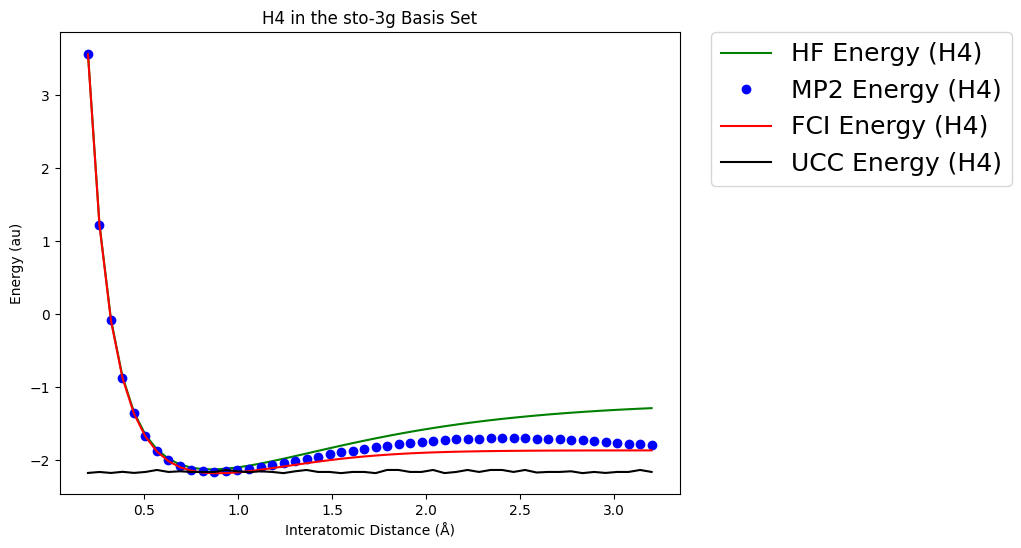

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from qat.fermion.chemistry.pyscf_tools import perform_pyscf_computation
from qat.fermion.transforms import transform_to_jw_basis, get_jw_code, recode_integer

# Define the interatomic distances for H4
r_H4 = np.linspace(0.2, 3.2, 50)

# Basis and other parameters
basis = "sto-3g"
spin = 0
charge = 0

mp2Energies_H4 = []
fciEnergies_H4 = []
hfEnergies_H4 = []
uccEnergies_H4 = []

# Calculate energies for H4
for distance in r_H4:
    geometry = [
        ('H', (0, 0, 0)),
        ('H', (0, 0, distance)),
        ('H', (0, 0, 2 * distance)),
        ('H', (0, 0, 3 * distance)),
    ]
    (
        rdm1,
        orbital_energies,
        nuclear_repulsion,
        n_electrons,
        one_body_integrals,
        two_body_integrals,
        info,
    ) = perform_pyscf_computation(
        geometry=geometry, basis=basis, spin=spin, charge=charge, run_fci=True
    )

    hfEnergies_H4.append(info['HF'])
    mp2Energies_H4.append(info['MP2'])
    fciEnergies_H4.append(info['FCI'])

    orbital_number = len(orbital_energies)
    nqbits = rdm1.shape[0] * 2

    # Wrap the hamiltonian data into the `MolecularHamiltonian` class.
    mol_h = MolecularHamiltonian(one_body_integrals, two_body_integrals, nuclear_repulsion)

    molecule = MoleculeInfo(hamiltonian=mol_h, n_electrons=n_electrons, noons = False,  orbital_energies=orbital_energies)

    hpq, hpqrs = convert_to_h_integrals(one_body_integrals, two_body_integrals)

    hamiltonian = ElectronicStructureHamiltonian(
        hpq, hpqrs, constant_coeff=nuclear_repulsion
    )

    transformation, code = transform_to_jw_basis, get_jw_code

    H_sp = transformation(H)
    model = H_sp
    nqbits = model.nbqbits

    # Express the cluster operator in spin terms
    cluster_ops_sp = [transformation(t_o) for t_o in cluster_ops]

    # Encoding the initial state to new encoding
    hf_init_sp = recode_integer(ket_hf_init, code(nqbits))

    n_steps =1 
    prog = Program()

    theta_0 = [np.random.uniform(0, 2*np.pi) for i in range(len(cluster_ops) * n_steps)]
    theta = [prog.new_var(float, f"\\theta_{i}") for i in range(len(theta_0))]

    circuit_ucc = ucc_action(theta, theta_0, model, cluster_ops_sp, hf_init_sp)
    
    uccEnergies_H4.append(circuit_ucc)


    

    

# Plot H4 energies
plt.figure(figsize=[8, 6])

plt.plot(r_H4, hfEnergies_H4, color='g', label='HF Energy (H4)')
plt.plot(r_H4, mp2Energies_H4, 'o', color='b', label='MP2 Energy (H4)')
plt.plot(r_H4, fciEnergies_H4, color='r', label='FCI Energy (H4)')
plt.plot(r_H4, uccEnergies_H4, color = 'black', label= 'UCC Energy (H4)' )

plt.ylabel("Energy (au)")
plt.xlabel("Interatomic Distance (Å)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
plt.title("H4 in the sto-3g Basis Set")

plt.show()